In [1]:
import datetime as dt
import os

import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler
from src.step3_modeling.ensemble import DefaultEnsemble
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase
from src.step3_modeling.var_models import VAR
from src.step3_modeling.multivariate import LakeMVT
from src.utils import create_rnbs_snapshot

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [2]:
def preprocess_data(split_date, lake_data, validation_steps=12, num_years_ahead=1):
    x_scaler = XArrayScaler()
    y_scaler = XArrayScaler()

    lake_snapshot = create_rnbs_snapshot(rnbs_data=lake_data.sel(variable="rnbs"),
                                         covariates=lake_data.sel(variable=["runoff", "evap", "precip"]), split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    lake_snapshot = lake_snapshot.apply_transformer(x_transformer=x_scaler, y_transformer=y_scaler)
    return lake_snapshot


lake_data = load_data(["rnbs", "precip", "evap", "runoff"]).dropna("Date")
scaled_lake_data = XArrayScaler().fit_transform(lake_data)
train_split = dt.datetime(1999, 12, 1)
snapshot = preprocess_data(train_split, lake_data)

snapshot.test_y

# original_values = snapshot.y_transformer.inverse_transform(snapshot.test_y)
# original_values

<xarray.DataArray (Date: 612, lake: 4)>
array([[-0.74853867,  0.3540659 ,  2.86741567,  1.28986629],
       [-1.05499685, -0.1893353 ,  0.99075354,  0.11095037],
       [-0.27421262,  0.78969614,  2.07873869,  0.99157355],
       ...,
       [-0.98114087, -1.63509893, -0.73266244, -1.19590738],
       [-0.99732445, -1.27820438, -1.00922316, -0.58328438],
       [-1.67894751, -0.92079332, -0.47286299, -0.28998121]])
Coordinates:
  * Date      (Date) datetime64[ns] 1950-01-01 1950-02-01 ... 2000-12-01
  * lake      (lake) object 'sup' 'mic_hur' 'eri' 'ont'
    variable  <U4 'rnbs'

In [3]:
models = {
    # "VARX": VAR(lags={"y": 3, "runoff": 3, "precip": 6, "evap": 2}, num_chains=4, num_samples=1000, num_warmup=1000),
    # "VAR": VAR(lags={"y": 3}, num_chains=4, num_samples=1000, num_warmup=500),
    "MVT": LakeMVT(),
    "Default": DefaultEnsemble()
}

In [4]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_lake_data.sel(variable="rnbs").rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot = preprocess_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=12)

        months_ahead = xr.DataArray(np.arange(1, 13), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot = preprocess_data(train_split, lake_data)
all_model_results = []
for name, model in models.items():
    fitted_model = fit_model(snapshot, model)
    predictions = run_forecasts(train_split, model).assign(model=name)
    all_model_results.append(predictions)
    
results_df = pd.concat(all_model_results)
results_df.head()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

value,Date,lake,months_ahead,true,lower,mean,std,upper,model
0,2000-01-01,eri,1.0,-0.672800,-0.979135,0.089574,0.656079,1.145128,MVT
1,2000-01-01,mic_hur,1.0,-0.997913,-1.544523,-0.493524,0.630059,0.472600,MVT
2,2000-01-01,ont,1.0,-0.531159,-1.079628,-0.156267,0.621008,0.900937,MVT
3,2000-01-01,sup,1.0,-1.102221,-2.053722,-1.047425,0.582128,-0.192695,MVT
4,2000-02-01,eri,2.0,0.164472,-0.651896,0.442862,0.653447,1.436219,MVT


In [5]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  interval_len  \
months_ahead model                                                           
1.0          Default  0.625932  0.391648  0.011942  0.913223      2.155240   
             MVT      0.628426  0.394166 -0.027452  0.882231      2.021252   
2.0          Default  0.626540  0.392402  0.012294  0.911157      2.155396   
             MVT      0.628182  0.393916 -0.026408  0.894628      2.018314   
3.0          Default  0.627022  0.392998  0.012609  0.911157      2.157786   
             MVT      0.628537  0.394321 -0.027164  0.890496      2.017545   
4.0          Default  0.636392  0.404553  0.021005  0.904959      2.159045   
             MVT      0.638614  0.407536 -0.017077  0.873967      2.017242   
5.0          Default  0.637165  0.405569  0.020267  0.904959      2.158189   
             MVT      0.639127  0.408124 -0.018950  0.888430      2.018268   
6.0          Default  0.635753  0.403823  0.018935  0.904959      2.154743   
             MVT      0.637895  0.406537 -0.019297  0.884298      2.016365   
7.0          Default  0.631133  0.397596  0.027072  0.904959      2.153092   
             MVT      0.632809  0.400313 -0.011589  0.894628      2.019479   
8.0          Default  0.630480  0.396656  0.029127  0.902893      2.152597   
             MVT      0.631668  0.398895 -0.010494  0.888430      2.018144   
9.0          Default  0.630028  0.396105  0.028829  0.902893      2.156632   
             MVT      0.631264  0.398390 -0.010228  0.888430      2.016218   
10.0         Default  0.630609  0.396931  0.027157  0.902893      2.156134   
             MVT      0.633018  0.400532 -0.013422  0.894628      2.014310   
11.0         Default  0.629682  0.395810  0.026266  0.902893      2.158133   
             MVT      0.631239  0.398295 -0.012933  0.894628      2.021807   
12.0         Default  0.630103  0.396375  0.025581  0.902893      2.155807   
             MVT      0.633393  0.401005 -0.013493  0.890496      2.019638   

                          crps      N  
months_ahead model                     
1.0          Default  0.347663  484.0  
             MVT      0.348807  484.0  
2.0          Default  0.348096  484.0  
             MVT      0.348787  484.0  
3.0          Default  0.348496  484.0  
             MVT      0.349050  484.0  
4.0          Default  0.352888  484.0  
             MVT      0.354036  484.0  
5.0          Default  0.353193  484.0  
             MVT      0.354482  484.0  
6.0          Default  0.352411  484.0  
             MVT      0.353793  484.0  
7.0          Default  0.349312  484.0  
             MVT      0.350792  484.0  
8.0          Default  0.348777  484.0  
             MVT      0.349865  484.0  
9.0          Default  0.348672  484.0  
             MVT      0.349683  484.0  
10.0         Default  0.349092  484.0  
             MVT      0.350609  484.0  
11.0         Default  0.348439  484.0  
             MVT      0.349555  484.0  
12.0         Default  0.348769  484.0  
             MVT      0.350775  484.0

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanea

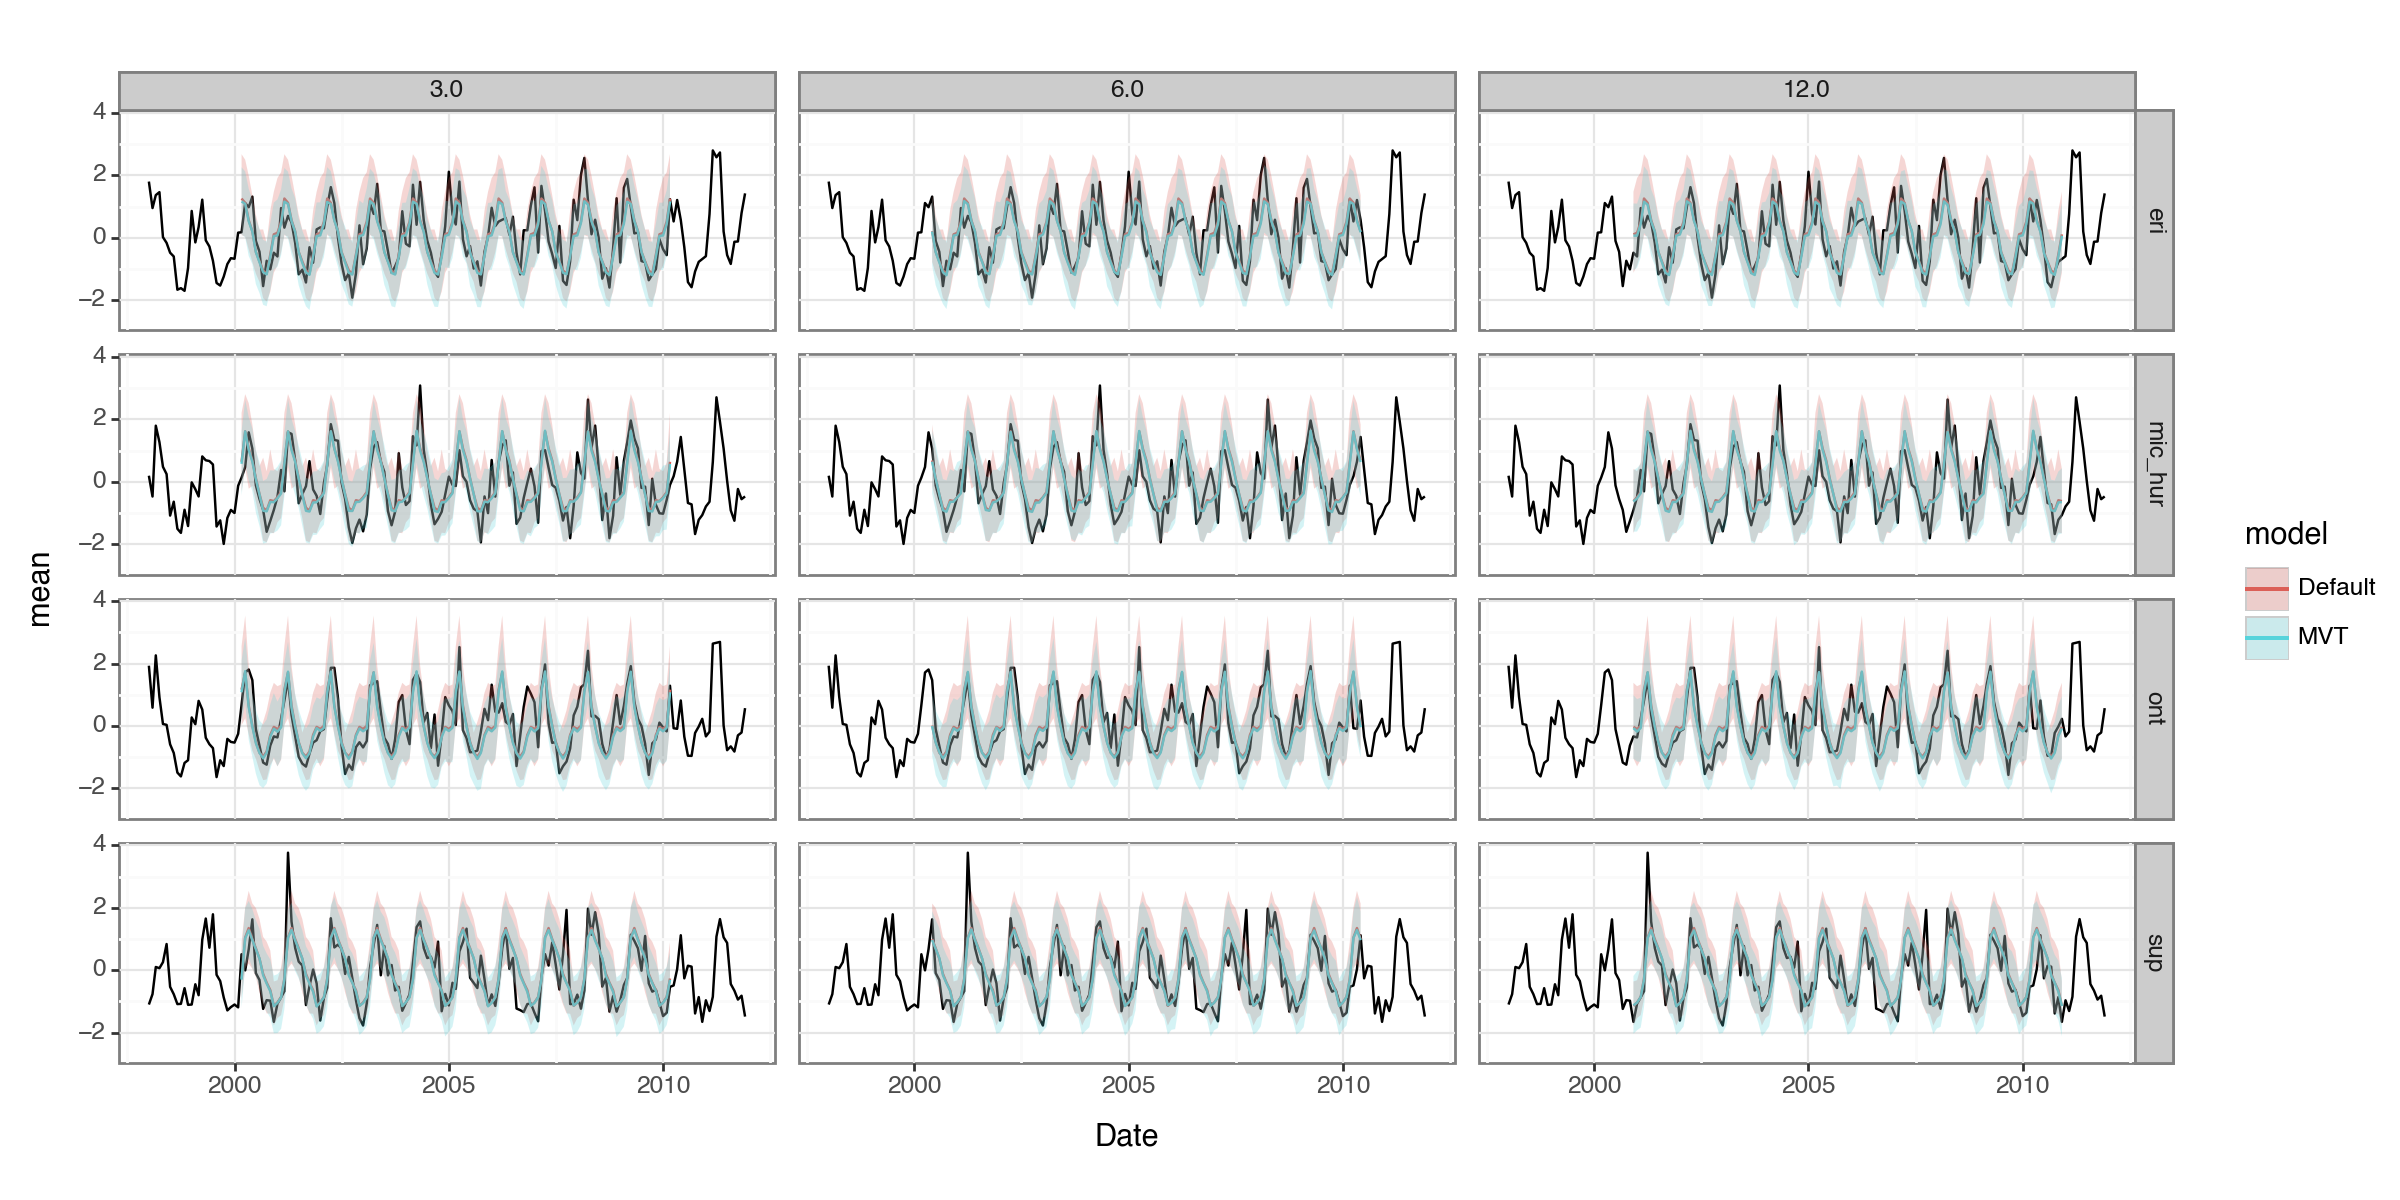

<Figure Size: (1200 x 600)>

In [6]:
og = scaled_lake_data.sel(variable="rnbs").to_dataframe(name="rnbs").reset_index().drop({"variable"}, axis=1)
result_subset = results_df[results_df["months_ahead"].isin([3, 6, 12])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean", fill="model"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean", color="model"))
        + facet_grid("lake~months_ahead")
        + scale_x_datetime(limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
                           labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
            mapping=aes(x="Date", ymin="lower", ymax="upper"),
            alpha=0.25,
        )
        + theme_bw()
        + theme(figure_size=(12, 6))
)
